# 05/05/23

This notebook is intended to evaluate the pretrained models of Chemformer. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from models.chemformer.molbart_dataset import Zinc
from models.chemformer.molbart import BARTModel
from models.chemformer.tokeniser import MolEncTokeniser
from models.chemformer.utils import REGEX
from models.chemformer.molbart_datamodule import MoleculeDataModule

from models.chemformer.sampler import DecodeSampler

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokeniser = MolEncTokeniser.from_vocab_file("tempdata/chemformer/bart_vocab.txt", REGEX, 272)
dataset = Zinc("tempdata/chemformer/zinc.csv")
data_module = MoleculeDataModule(
  dataset,
  tokeniser,
  batch_size=32,
  max_seq_len=512,
  task="mask_aug",
  train_token_batch_size=None,
  num_buckets=12, 
  val_idxs = dataset.val_idxs,
  test_idxs = dataset.test_idxs,
  augment="DO IT",
  unified_model=False,
)

Using a batch size of 32.
Using molecule data module with augmentations.


In [4]:
sampler = DecodeSampler(tokeniser, 512)
model = BARTModel.load_from_checkpoint("tempdata/chemformer/model.ckpt", decode_sampler = sampler)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:201: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.2.3 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file tempdata/chemformer/model.ckpt`


In [5]:
data_module.setup()
val_dl = data_module.val_dataloader()
for batch in val_dl:
  obj = batch
  break

In [6]:
model = model.cuda()
obj = {k : v.cuda() if type(v) is torch.Tensor else v for k,v in obj.items()}
print(f"{model.device=}")
for k, v in obj.items():
  if hasattr(v, "device"):
    print(f"{k} {v.device=}")

model.device=device(type='cuda', index=0)
encoder_input v.device=device(type='cuda', index=0)
encoder_pad_mask v.device=device(type='cuda', index=0)
decoder_input v.device=device(type='cuda', index=0)
decoder_pad_mask v.device=device(type='cuda', index=0)
target v.device=device(type='cuda', index=0)
target_mask v.device=device(type='cuda', index=0)


### Inputs

In [29]:
tokens = tokeniser.convert_ids_to_tokens(obj["encoder_input"].T)
strs = tokeniser.detokenise(tokens)
strs

targets = obj["target_smiles"]

for idx, (target, my_str) in enumerate(zip(targets, strs)):
  print(f"[{idx}]\n\t{target=}\n\t{my_str=}")

[0]
	target='COc1ccc(Cn2cc(NC(=O)N3CC[C@@H](Oc4ccc(Cl)cc4)C3)cn2)cc1'
	my_str='O(C<MASK>1<MASK>n2cc(NC(<MASK>N<MASK>[C@H]<MASK><MASK><MASK><MASK>(Cl)<MASK>CC3)c<MASK>c1'
[1]
	target='CC(=O)Nc1ccc(N2C[C@@H](C(=O)N[C@H]3C=CCCC3)CC2=O)cc1'
	my_str='<MASK>1=C<MASK>NC<MASK>C(=O)N(c3ccc(NC<MASK>=O)<MASK>c<MASK>)=O<MASK>CC1'
[2]
	target='O=C(NCCCCO)[C@H]1[C@H](C(F)(F)F)[C@H]2CC[C@H]1O2'
	my_str='O1[C@H]2[C@@H](C(F)(F)F)[C@H](C(=O)NCCC<MASK>C<MASK>'
[3]
	target='COCCOc1cccc(NC(=O)N(CC(=O)O)C2CCCC2)c1'
	my_str='c1<MASK><MASK><MASK>NC(<MASK>(<MASK>=O)C2C<MASK>2)=O)cc1OCCOC'
[4]
	target='COc1cc(OC)c(C(=O)N[C@H]2COc3c(Cl)cccc32)cc1OC'
	my_str='O=<MASK>c<MASK>cc(OC)c(OC)<MASK><MASK>[C@@H]1c2cccc(Cl<MASK><MASK>c<MASK><MASK>1'
[5]
	target='Cc1cccc2nnc([C@@]34CCCC[C@@H]3CNC4)n12'
	my_str='c<MASK>c([C@]34<MASK>CC3)CN<MASK>n<MASK>C)ccc2'
[6]
	target='CS(=O)(=O)CCCCNC(=O)[C@H](Sc1ccc(F)cc1F)c1ccccc1'
	my_str='c1c<MASK>([C@@H](S<MASK><MASK>F)<MASK>)cc2)C<MASK>NCCCCS(=<MASK>(C)=O<MASK>c1'
[7]
	target='CN1C

### Using Beam Search

In [38]:
from textwrap import indent

In [36]:
model.test_sampling_alg = "beam"
print(f"Search Algorithm: {model.test_sampling_alg}")
beam_output = model.test_step(obj, -1)
mol_strs, log_lhs = model.sample_molecules(obj, "beam")

Search Algorithm: beam


test_molecular_top_k_accuracy: (```models/chemformer/sampler.py```)
- Choose top k beam search results (10), sorted by log-likelihood
- Check if any of those match the intended target. If, so -> success, else -> fail

In [43]:
display(beam_output)
for idx, (target, my_str, beam_str, log_lh) in enumerate(zip(targets, strs, mol_strs, log_lhs)):
  print(f"[{idx}]\n\t{target=}\n\t{my_str=}\n\t{log_lh=}")
  print(f"\tbeam_str: ")
  print(indent("\n".join(mol_strs[idx]), prefix="\t\t"))

{'test_loss': 0.2379920482635498,
 'test_token_acc': tensor(0.8887, device='cuda:0'),
 'test_perplexity': tensor(0., device='cuda:0'),
 'test_invalid_smiles': 0.0,
 'test_molecular_accuracy': 0.21875,
 'test_molecular_top_1_accuracy': 0.21875,
 'test_molecular_top_2_accuracy': 0.25,
 'test_molecular_top_3_accuracy': 0.25,
 'test_molecular_top_5_accuracy': 0.28125,
 'test_molecular_top_10_accuracy': 0.3125}

[0]
	target='COc1ccc(Cn2cc(NC(=O)N3CC[C@@H](Oc4ccc(Cl)cc4)C3)cn2)cc1'
	my_str='O(C<MASK>1<MASK>n2cc(NC(<MASK>N<MASK>[C@H]<MASK><MASK><MASK><MASK>(Cl)<MASK>CC3)c<MASK>c1'
	log_lh=[-9.995026588439941, -10.035225868225098, -10.152423858642578, -10.194649696350098, -10.203709602355957, -10.253393173217773, -10.291241645812988, -10.323857307434082, -10.43252944946289, -10.60340404510498]
	beam_str: 
		c1cc(OC)ccc1Cn1cc(NC(=O)N2CCO[C@@H](c3ccc(Cl)cc3)C2)cn1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2C[C@H](Oc3ccc(Cl)cc3)CC2)c1
		c1c(OC)ccc(Cn2ncc(NC(=O)N3CC[C@@H](Oc4ccc(Cl)cc4)C3)c2)c1
		c1c(OC)ccc(Cn2ncc(NC(=O)N3CCC[C@H]3c3ccc(Cl)cc3)c2)c1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2CCO[C@@H](c3ccc(Cl)cc3)C2)c1
		c1c(OC)ccc(Cn2ncc(NC(=O)N3C[C@H](c4ccc(Cl)cc4)OCC3)c2)c1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2CC[C@@H](Oc3ccc(Cl)cc3)C2)c1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2C[C@H](c3ccc(Cl)cc3)OCC2)c1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2CCC[C@H]2c2ccc(Cl)cc2)c1
		c1cc(OC)ccc1Cn1ncc(NC(=O)N2[C@H](c3ccc(Cl)cc3)CC2)c1
[1]
	target='CC(=O)Nc1ccc(N2C[

### Using Greedy Search

In [44]:
model.test_sampling_alg = "greedy"
print(f"Search Algorithm: {model.test_sampling_alg}")
greedy_output = model.test_step(obj, -1)
mol_strs, log_lhs = model.sample_molecules(obj, "greedy")

Search Algorithm: greedy


In [47]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

{'test_loss': 0.2379920482635498,
 'test_token_acc': tensor(0.8887, device='cuda:0'),
 'test_perplexity': tensor(0., device='cuda:0', grad_fn=<MeanBackward0>),
 'test_invalid_smiles': 0.0,
 'test_molecular_accuracy': 0.15625}

[0]
	target='COc1ccc(Cn2cc(NC(=O)N3CC[C@@H](Oc4ccc(Cl)cc4)C3)cn2)cc1'


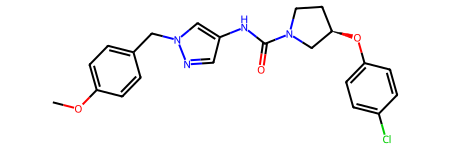

	my_str='O(C<MASK>1<MASK>n2cc(NC(<MASK>N<MASK>[C@H]<MASK><MASK><MASK><MASK>(Cl)<MASK>CC3)c<MASK>c1'
	greedy_str='c1c(Cl)ccc([C@H]2CN(C(=O)Nc3cnn(Cc4ccc(OC)cc4)c3)CCO2)c1'
	log_lh=-8.724369049072266


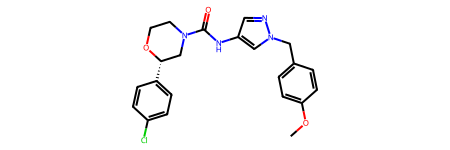

[1]
	target='CC(=O)Nc1ccc(N2C[C@@H](C(=O)N[C@H]3C=CCCC3)CC2=O)cc1'


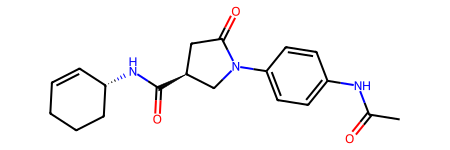

	my_str='<MASK>1=C<MASK>NC<MASK>C(=O)N(c3ccc(NC<MASK>=O)<MASK>c<MASK>)=O<MASK>CC1'
	greedy_str='C1CCC=C1CCNC(=O)[C@@H]1CN(c2ccc(NC(=O)C)cc2)C(=O)C1'
	log_lh=-11.33339786529541


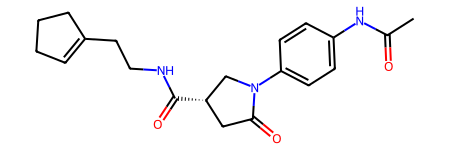

[2]
	target='O=C(NCCCCO)[C@H]1[C@H](C(F)(F)F)[C@H]2CC[C@H]1O2'


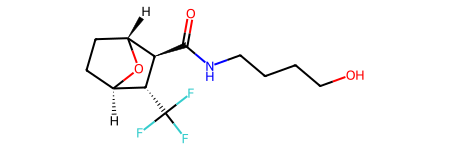

	my_str='O1[C@H]2[C@@H](C(F)(F)F)[C@H](C(=O)NCCC<MASK>C<MASK>'
	greedy_str='C(CCNC(=O)[C@@H]1[C@@H]2O[C@H](CC2)[C@H]1C(F)(F)F)CCC'
	log_lh=-25.318500518798828


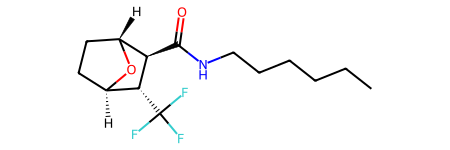

[3]
	target='COCCOc1cccc(NC(=O)N(CC(=O)O)C2CCCC2)c1'


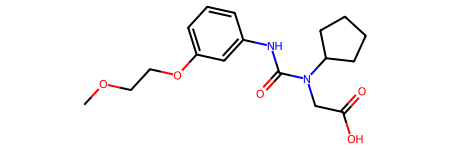

	my_str='c1<MASK><MASK><MASK>NC(<MASK>(<MASK>=O)C2C<MASK>2)=O)cc1OCCOC'
	greedy_str='C(COc1cc(NC(=O)N[C@@H](C2CCCCC2)CC(=O)N)ccc1)OC'
	log_lh=-16.216228485107422


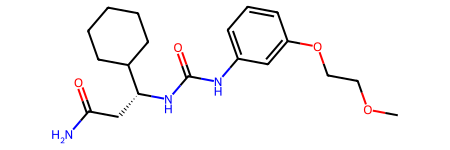

[4]
	target='COc1cc(OC)c(C(=O)N[C@H]2COc3c(Cl)cccc32)cc1OC'


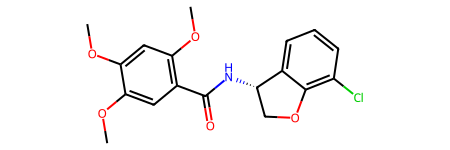

	my_str='O=<MASK>c<MASK>cc(OC)c(OC)<MASK><MASK>[C@@H]1c2cccc(Cl<MASK><MASK>c<MASK><MASK>1'
	greedy_str='c1ccc2c(c1Cl)OCCC[C@@H]2NC(=O)NCc1cc(OC)c(OC)cc1'
	log_lh=-15.321375846862793


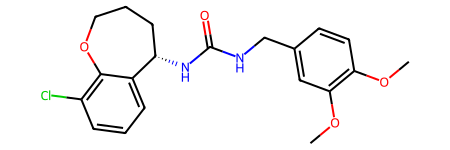

[5]
	target='Cc1cccc2nnc([C@@]34CCCC[C@@H]3CNC4)n12'


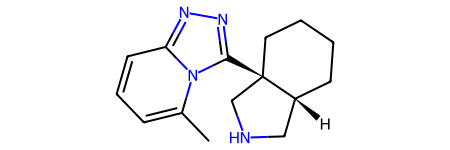

	my_str='c<MASK>c([C@]34<MASK>CC3)CN<MASK>n<MASK>C)ccc2'
	greedy_str='c1ccc(C)c2nc([C@]34CNC[C@H]3CCC4)[nH]c12'
	log_lh=-10.657437324523926


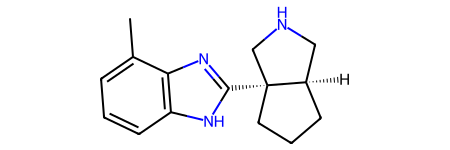

[6]
	target='CS(=O)(=O)CCCCNC(=O)[C@H](Sc1ccc(F)cc1F)c1ccccc1'


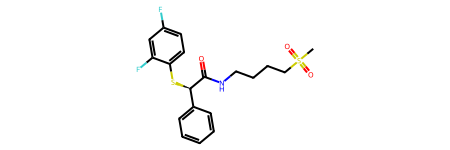

	my_str='c1c<MASK>([C@@H](S<MASK><MASK>F)<MASK>)cc2)C<MASK>NCCCCS(=<MASK>(C)=O<MASK>c1'
	greedy_str='c1ccccc1[C@H](C(NCCCCS(=O)(=O)C)=O)Sc1ccc(F)c(F)c1'
	log_lh=-7.988275527954102


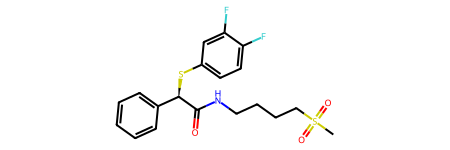

[7]
	target='CN1CCN([C@H]2CCN(C(=O)[C@@H](Cc3ccccc3)NC(N)=O)C2)CC1'


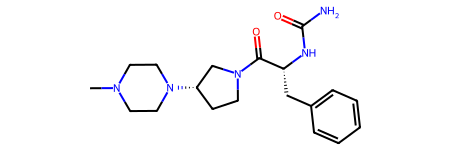

	my_str='C(N[C@@H](C(N1C<MASK>N2<MASK>C)CC2<MASK><MASK><MASK>c1)(<MASK>)<MASK>'
	greedy_str='C1CN(C(=O)[C@@H](c2ccccc2)NC(=O)CC)CCC1N1CCN(C)CC1'
	log_lh=-12.146084785461426


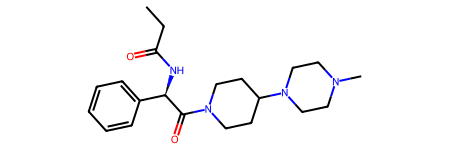

[8]
	target='O=C(Cc1csc(-c2ccoc2)n1)OC[C@@H]1COCCO1'


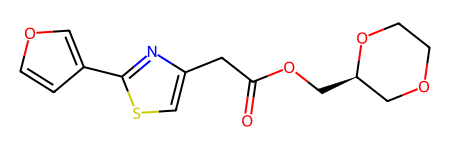

	my_str='n1c(CC(=O<MASK>[C@@H]2C<MASK>CO2)csc1-c1cc<MASK>1'
	greedy_str='c1cccc(-c2scc(CC(=O)NC[C@@H]3CCCCO3)n2)c1'
	log_lh=-15.947779655456543


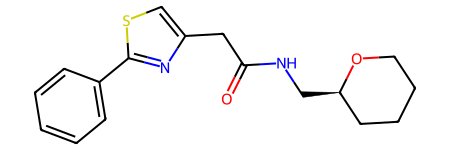

[9]
	target='CC1(C(=O)N2CCOC[C@]3(CN(C(=O)c4cnc5c(c4)CCNCC5)CCO3)C2)COC1'


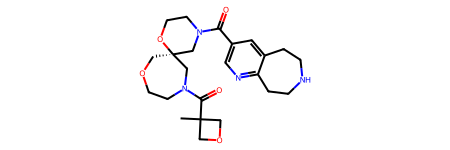

	my_str='C1OCC1(C)C(N1C[C@@]<MASK>CN(C<MASK>c<MASK>(c3<MASK>N<MASK>)=O<MASK>CO2)COCC1)<MASK>'
	greedy_str='C1CN(C(=O)c2cc3c(cc2)N(C)CC3)C[C@@]2(CN(C(=O)C3(C)COC3)CCOC2)O1'
	log_lh=-8.028717994689941


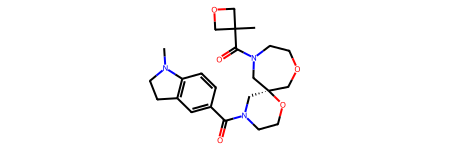

[10]
	target='Cc1c(NC2CCS(=O)(=O)CC2)nn2c(C(F)(F)F)nnc2c1C'


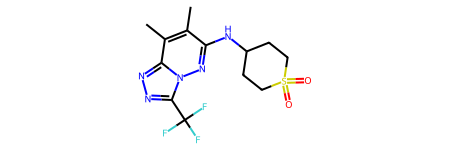

	my_str='n1c2c(C)c(<MASK>c(NC3<MASK><MASK>CC3)nn2c<MASK>C(F)<MASK>)n1'
	greedy_str='C1CC(Nc2nn3c(C(F)(F)F)nnc3c(C)c2C)CCC1CC'
	log_lh=-16.64783477783203


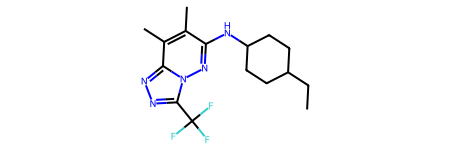

[11]
	target='COC1(C)CN(c2nnc(-c3cccc(C#N)c3)n2Cc2ccco2)C1'


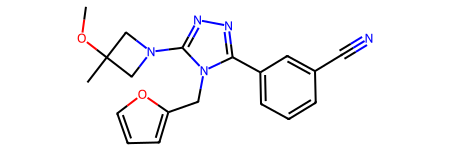

	my_str='c<MASK>#N)<MASK>cc1-<MASK>CC(C)(OC)C2)n1Cc<MASK><MASK>'
	greedy_str='c1(-c2ccc(C#N)cc2)nnc(N2CC(OC)(C)C2)n1Cc1ccccc1'
	log_lh=-16.09295654296875


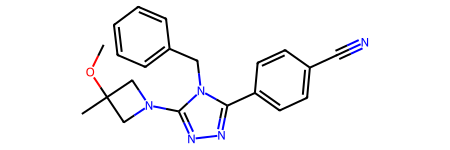

[12]
	target='C[C@H](O)[C@H]1CN(C(=O)N[C@@H](Cc2nccn2C)c2ccccc2)CCO1'


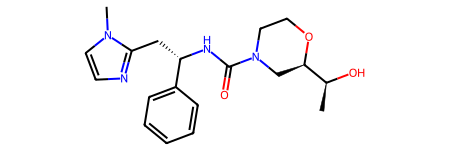

	my_str='n1(C)c(C[C@H](NC<MASK>2<MASK>(C)O)O<MASK>2)=O)c2<MASK>ccc2<MASK><MASK>'
	greedy_str='c1cccc([C@H](Cc2nccn2C)NC(=O)N2CCO[C@@H]([C@@H](O)C)C2)c1'
	log_lh=-8.078119277954102


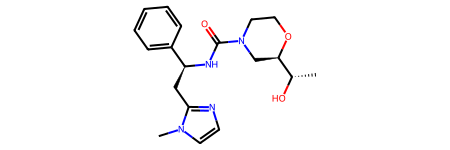

[13]
	target='O=C(CCNC(=O)c1cccc(OC(F)F)c1)NCc1ccccc1'


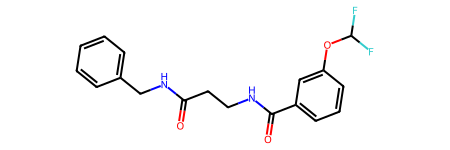

	my_str='C(N<MASK>1cccc(OC(F)F)c1)=O)CC(N<MASK><MASK>1<MASK>'
	greedy_str='C(CC(N1CCCCC1)=O)NC(=O)Nc1cccc(OC(F)F)c1'
	log_lh=-15.121685981750488


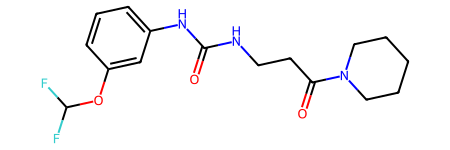

[14]
	target='COC[C@@H]1CN(c2nnc(C3CCC3)n2CCCOC[C@H]2CCCO2)C[C@H](C)O1'


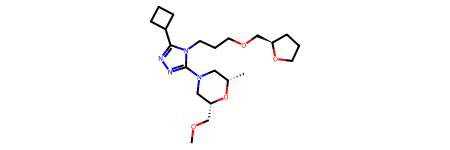

	my_str='C1(<MASK>nn<MASK><MASK>(COC<MASK><MASK>C<MASK>[C@@H]<MASK>)CCC1'
	greedy_str='C1CCC1c1nnc(N2CCC(COC)CC2)n1C[C@@H]1CCC[C@@H]1C'
	log_lh=-17.749906539916992


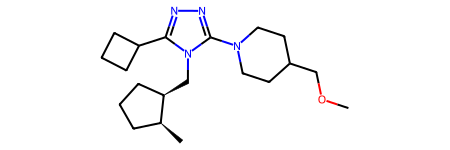

[15]
	target='CC(=O)Nc1ccc(CN(C)[C@H]2CCCN(c3cccnn3)C2)cc1'


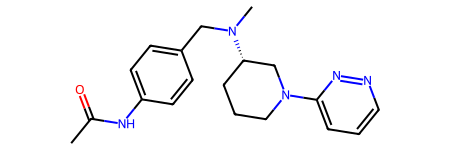

	my_str='O=C(<MASK>c(<MASK>([C@H]2CCCN<MASK>ccc<MASK><MASK>2)C)cc1<MASK>'
	greedy_str='c1cccc(CN2C[C@@H](N(C)Cc3ccc(C(=O)O)cc3)CCC2)c1'
	log_lh=-21.835338592529297


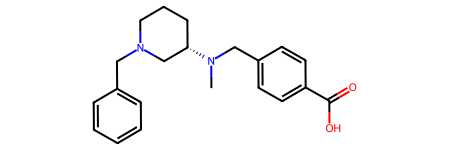

[16]
	target='O=C(CCCc1ccccc1F)N1CCCC2(CCN(C(=O)[C@@H]3[C@H]4C=CS[C@H]43)CC2)C1'


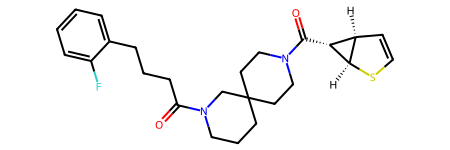

	my_str='O=C(C<MASK><MASK>Cc1c(<MASK>c<MASK>1CC2(CCN(C(=O)[C@@H]3[C@H]<MASK>=CS<MASK>CC2)<MASK>C1'
	greedy_str='C1C2(CCN(C(=O)[C@@H]3[C@@H]4C=CS[C@@H]43)CC2)CCCN1C(=O)CCCc1ccccc1F'
	log_lh=-12.168105125427246


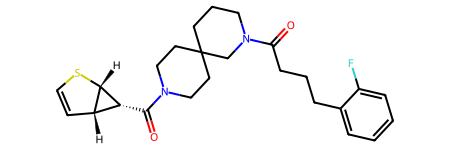

[17]
	target='CN(CCN(C)c1ccccc1)C(=O)Cc1ccccc1O[C@H]1CCOC1'


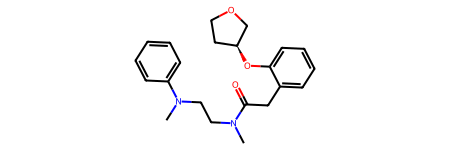

	my_str='c1c(CC(=O)N(C)CCN(C)c2c<MASK>2)<MASK>2CO<MASK>c1'
	greedy_str='c1cccc(N(CCN(C)C(=O)Cc2ccc(O[C@@H]3COCC3)cc2)C)c1'
	log_lh=-8.008293151855469


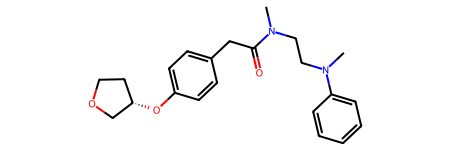

[18]
	target='Cc1ccc(NC(=O)N[C@@H]2CCCc3ccc(F)cc32)cc1C(=O)N(C)C(C)C'


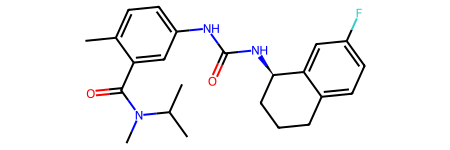

	my_str='c1cc(C)c(C(N(C(C)C)<MASK>)=<MASK>1N<MASK><MASK>[C@H]1c2cc(F)<MASK>c2CCC<MASK>'
	greedy_str='c1c(F)cc2c(c1)CCC[C@H]2NC(=O)Nc1ccc(C)c(C(N(C)C(C)C)=O)c1'
	log_lh=-7.345407962799072


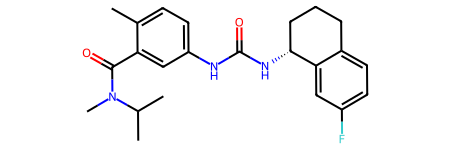

[19]
	target='Cc1nc(C[C@H](O)CSc2cccc(F)c2)n(C)n1'


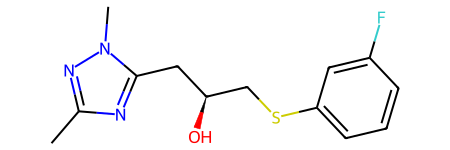

	my_str='C(Sc1cc(F)ccc1)[C@H](Cc1nc(C)nn1C)O'
	greedy_str='c1ccc(SC[C@@H](O)Cc2nc(C)nn2C)cc1F'
	log_lh=-6.914482593536377


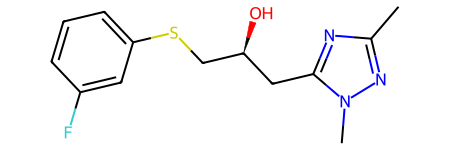

[20]
	target='C[C@@H]1CCC[C@H](C(=O)NC2CCN(C(=O)CCn3ccnn3)CC2)C1'


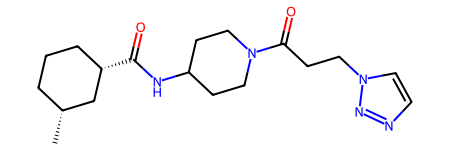

	my_str='n<MASK>1CC<MASK><MASK>(N1<MASK>(NC(=O)<MASK><MASK>CC2)CC1)=O'
	greedy_str='C1CC(NC(=O)C2(C)CCC2)CCN1C(=O)CCCn1cccn1'
	log_lh=-15.644120216369629


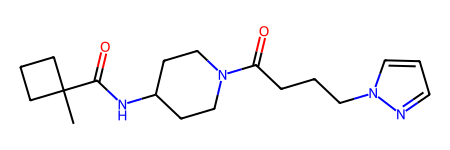

[21]
	target='CC[C@H](CCO)CNCc1nc(C(C)(C)C)cs1'


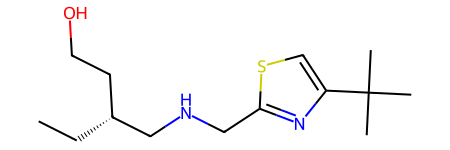

	my_str='n1c(<MASK><MASK>[C@H](CC)CCO<MASK><MASK>)C'
	greedy_str='C(C)(C)c1nc(CN[C@H](CC)CCO)cs1'
	log_lh=-26.00994873046875


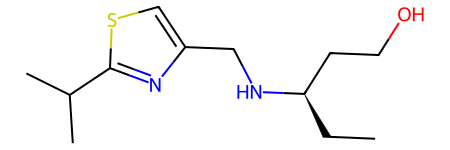

[22]
	target='C[C@H]1CCCc2ncc(C(=O)N(C)CCN(C)C(=O)[C@@]34COC[C@@H]3C4)n21'


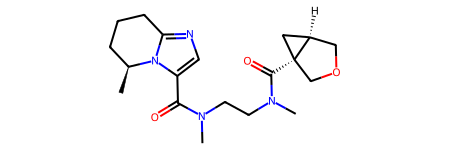

	my_str='C(=O)([C@@]12COC[C@@H]1C2)N(CCN(C(c1n2c(nc1)CCC[C@@H]2C)=<MASK>)C)C'
	greedy_str='C1CCc2ncc(C(=O)N(C)CCN(C)C(=O)[C@]34C[C@H]3COC4)n2[C@H]1C'
	log_lh=-8.665655136108398


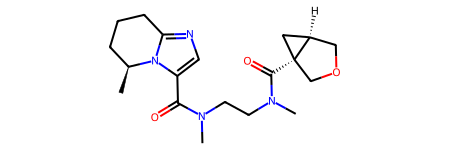

[23]
	target='COC(=O)c1cnc([C@H](C)N[C@@H](C2CCC2)[C@@H]2CCCO2)s1'


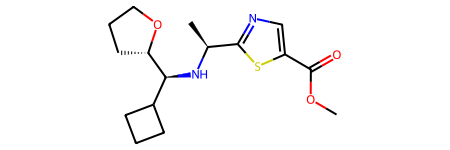

	my_str='C1CC[C@@H](<MASK><MASK>N[C@H](c2ncc(C(<MASK>)=O)<MASK>C2CCC2)O1'
	greedy_str='C1CCC1[C@@H](c1sc(C(OC)=O)cn1)NC(=O)NC[C@@H]1CCCO1'
	log_lh=-13.180770874023438


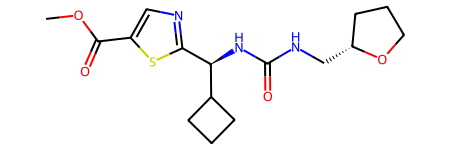

[24]
	target='CCn1ncnc1-c1ccc(-c2nc(C[C@@H]3CCCO3)no2)cc1'


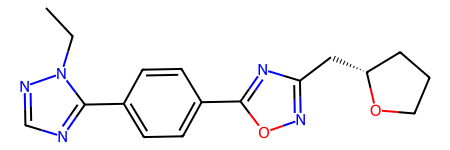

	my_str='C1[C@@H](C<MASK>noc(-c3ccc<MASK>c4n(CC)ncn4<MASK>)n2)OCC<MASK>'
	greedy_str='c1(-c2ccc(-c3ncnn3CC)cc2)nc(C[C@@H]2CCCO2)no1'
	log_lh=-8.821310043334961


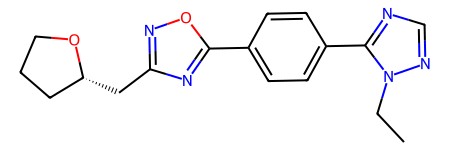

[25]
	target='Cc1ccccc1OCCN1CC[C@@H](N(C)C(=O)[C@]2(C)C=CCC2)C1'


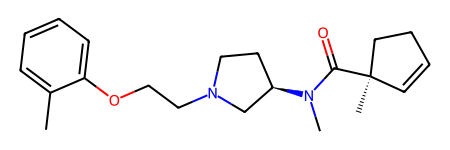

	my_str='c<MASK>CCN<MASK>CC[C@@H](N(C(=O<MASK>)C=CCC3)C)C2)<MASK>c1'
	greedy_str='C1CC=C[C@@]1(C)C(N(C)[C@@H]1CCN(CCc2ccccc2)C1)=O'
	log_lh=-14.55291748046875


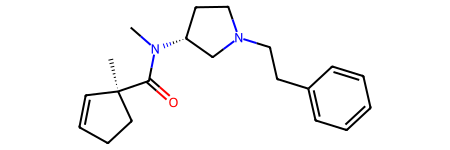

[26]
	target='C[C@@H]1CCCN(c2cc(NCc3ccc(NC(=O)c4cccnc4)cc3)ncn2)C1'


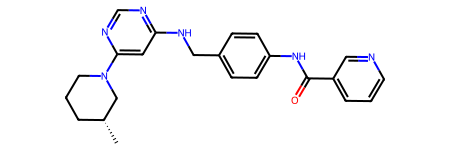

	my_str='c<MASK>c(N<MASK>(c2cccnc2)=O<MASK>cc1CNc1ncnc(N2C[C@H](<MASK>CC2)<MASK>1'
	greedy_str='c1cc(CNc2ncnc(N3C[C@H](CO)CCC3)c2)ccc1NC(c1cnccc1)=O'
	log_lh=-11.995810508728027


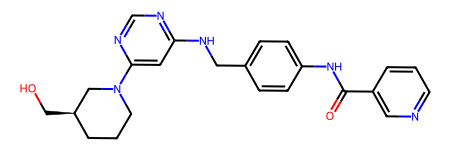

[27]
	target='C[C@@H]1CO[C@@H](C(=O)N2CC[C@@H]3CN(Cc4cscn4)C[C@@H]3CC2)C1'


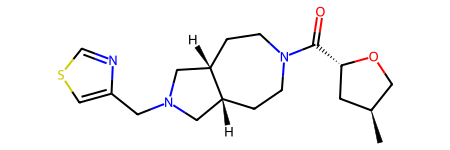

	my_str='c1(CN2C[C@H]<MASK>(CCN(C([C@@H]4<MASK>C4)=O)C<MASK><MASK><MASK>)cscn1'
	greedy_str='C1CN(C(=O)[C@@H]2CCCOC2)CC[C@H]2CN(Cc3ncsc3)C[C@@H]12'
	log_lh=-11.176806449890137


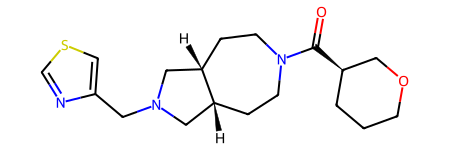

[28]
	target='COCCN1CCC[C@@H]1CNC(=O)NCc1ccc2c(c1)CN(C(=O)OC(C)(C)C)C2'


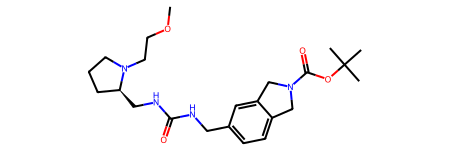

	my_str='<MASK>1(C<MASK>)NCc2cc3c(cc<MASK>(<MASK>C)C)<MASK>)C3)CCCN1CCOC'
	greedy_str='C(CN1CCC[C@H]1C(=O)NCc1ccc2c(c1)CN(C(=O)C(C)C)C2)OC'
	log_lh=-10.658808708190918


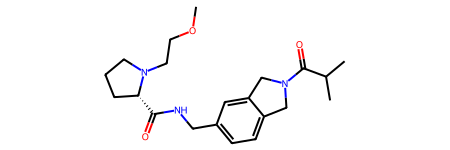

[29]
	target='COC(=O)C1(CNC(=O)c2ccccc2NC(=O)OC(C)(C)C)CC1'


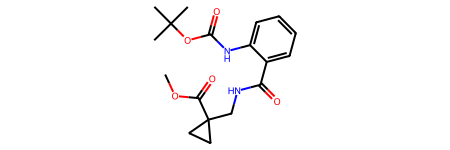

	my_str='C1CC1(C<MASK>OC)=O)CNC(<MASK>1ccccc1NC(OC(C)(<MASK><MASK>'
	greedy_str='C(C1(CNC(=O)Cc2ccccc2NC(=O)OC(C)(C)C)CC1)(OC)=O'
	log_lh=-9.45793628692627


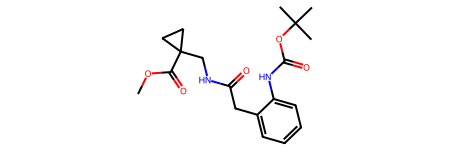

[30]
	target='CCOc1cc2c(cc1[C@H](O)CNC(C)C)O[C@H](C)C2'


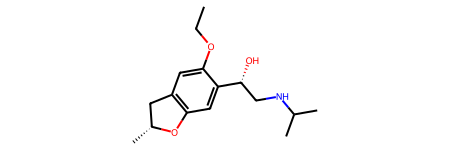

	my_str='c1<MASK>(O)CN<MASK>(C)C)c(OCC)cc<MASK>(C)C2'
	greedy_str='C(C)Oc1cc2c(cc1[C@H](O)CNCC(C)C)O[C@H](C)C2'
	log_lh=-10.888936996459961


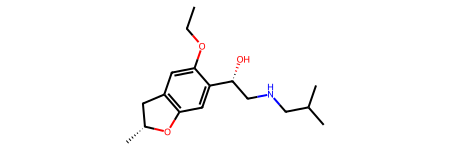

[31]
	target='CC(C)c1nnc(NC(=O)CCC(=O)Nc2ccc(OC(F)F)cc2OC(F)F)s1'


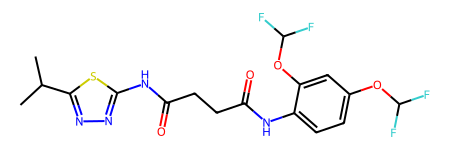

	my_str='c1(NC(=<MASK><MASK>CCC(Nc2ccc(OC(F)<MASK>OC(<MASK><MASK>O)nnc(C(C)C)s1'
	greedy_str='C(CC(Nc1ccc(OC(F)F)c(OC(F)F)c1)=O)C(Nc1sc(C(C)C)nn1)=O'
	log_lh=-9.479239463806152


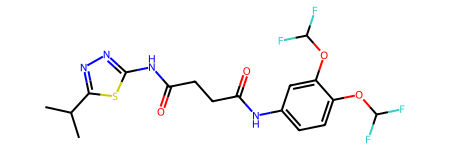

In [50]:
display(greedy_output)
for idx, (target, my_str, greedy_str, log_lh) in enumerate(zip(targets, strs, mol_strs, log_lhs)):
  print(f"[{idx}]\n\t{target=}")
  display(Chem.MolFromSmiles(target))
  print(f"\t{my_str=}\n\t{greedy_str=}\n\t{log_lh=}")
  display(Chem.MolFromSmiles(greedy_str))
  